# Description:

    Investigate Core microbiome of different groups of samples
    Note: log2fold change file was run on Full-Sparsity3in3



# Setting variables

In [1]:

log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'


# Init

In [2]:

%load_ext rpy2.ipython

In [83]:
%%R
library(vegan)
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(reshape2)
library(dplyr)
library(tidyr)
library(VennDiagram)
#library(DESeq2)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: grid

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: futile.logger

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘VennDiagram’


  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: The following object is masked from ‘package:ape’:

    rotate


  warnings.warn(x, RRuntimeWarning)


In [84]:
%%R 
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r'
physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


# Venn Diagram of occurance in sample types

In [85]:
%%R
physeq.Full %>% sample_data %>%
    colnames

 [1] "X.sample"            "Library"             "Primer_Plate"       
 [4] "Primer_Well_ID"      "primerFR_ID_byPlate" "primerFR_ID_total"  
 [7] "barcode_ID"          "PlotID"              "Plant"              
[10] "Plot"                "Treatment"           "Rep"                
[13] "DAP"                 "Sampling"            "PlantSample"        
[16] "Type"                "Grass_Broad"         "Status"             
[19] "Subfamily"           "fwd_barcode"         "rev_barcode"        
[22] "Planted"             "Biomass_P"           "SLA"                
[25] "Leaf_N"              "Leaf_C"              "LeafC_N"            
[28] "LNa"                 "Plant_N"             "Plant_C"            
[31] "Plant_CN"            "d15N"                "tN_p"               
[34] "BX_activity_g"       "CB_activity_g"       "LAP_activity_g"     
[37] "NAG_activity_g"      "BX_rel"              "CB_rel"             
[40] "LAP_rel"             "NAG_rel"             "NO3_ug_g"           
[43] "

In [86]:
%%R
# merge samples by sample type (rhizosphere vs baresoil) and convert to PA
phy.2pa = NULL 
phy.2pa = physeq.Full %>%
    merge_samples("Planted") %>%
    transform_sample_counts(function(x) ifelse(x == 0,0,1) ) %>%
    otu_table %>%  t() %>% as.data.frame 

  head(phy.2pa)  
    

         BARE Rhizosphere
OTU.4087    0           1
OTU.2009    1           1
OTU.5899    1           1
OTU.4181    1           1
OTU.3052    1           1
OTU.1890    1           1


In [87]:
%%R

barecount = filter(phy.2pa, BARE == 1) %>% nrow
plantcount = filter(phy.2pa, Rhizosphere == 1) %>% nrow
sharedcount = filter(phy.2pa, Rhizosphere == 1 & BARE == 1) %>% nrow
#check rhizosphere OTUs not in bare soil
filter(phy.2pa, Rhizosphere == 0 & BARE == 1) %>% nrow
barecount

[1] 4733


(polygon[GRID.polygon.55], polygon[GRID.polygon.56], polygon[GRID.polygon.57], polygon[GRID.polygon.58], text[GRID.text.59], text[GRID.text.60], text[GRID.text.61], text[GRID.text.62], text[GRID.text.63]) 


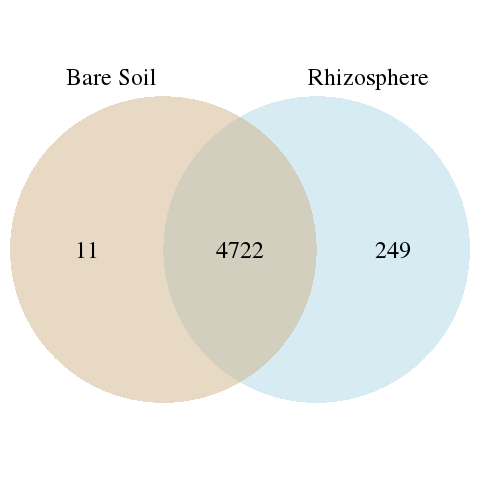

In [88]:
%%R
# Draw venn diagrame
# caution, ordering of labels and colors is backward, always check against actual counts 
# to confirm interpretations

grid.newpage()
draw.pairwise.venn(area1 = plantcount, area2 = barecount, cross.area = sharedcount,
                   category = c("Bare Soil", "Rhizosphere"), lty = rep("blank", 2), 
                 fill = c("lightblue", "tan"), alpha = rep(0.5, 2), cex = 2,
                   cat.dist = .15, cat.cex = 2, scaled = FALSE, rotation.degree = 180)

# Explore rhizosphere only OTUs

In [44]:
%%R
phy.2pa$OTU = rownames(phy.2pa) 
RE = filter(phy.2pa, Rhizosphere == 1 & BARE == 0) 
RElist = RE$OTU
RE = NULL


In [45]:
%%R
#load rhizosphere responders and determine if rhizosphere endemic taxa are included
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
RhizEnrichedFile = file.path(workDir, 'bare-plant.csv')
df.l2fc = read.csv(RhizEnrichedFile)


In [46]:
%%R

responders = df.l2fc %>%
            filter(log2FoldChange > 0 & p.adj < 0.05) %>%
            .$OTU %>%
            unique
length(responders)

[1] 1506


In [47]:
%%R
overlap <- calculate.overlap(
x = list(
"RE" = RElist,
"Responders" = responders
))


Error in withVisible({ : could not find function "calculate.overlap"


In [48]:
%%R
overlap


Error in withVisible({ : object 'overlap' not found


In [49]:
%%R
phy.RE = transform_sample_counts(physeq.Full, function(x) x/sum(x)) %>%
            prune_taxa(RElist, .) %>% 
            subset_samples(Planted == "Rhizosphere")
          
phy.RE
phy.pr = transform_sample_counts(physeq.Full, function(x) x/sum(x)) %>%
            prune_taxa(as.character(responders), .) %>%
            subset_samples(Planted == "Rhizosphere")

In [50]:
%%R
allotu = phy.pr %>% otu_table %>% as.data.frame() %>% melt()
reotu = phy.RE %>% otu_table %>% as.data.frame() %>% melt()
head(reotu)

/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: No id variables; using all as measure variables

  warnings.warn(x, RRuntimeWarning)


           variable value
1 sample5-1.22_Nneg     0
2 sample5-1.22_Nneg     0
3 sample5-1.22_Nneg     0
4 sample5-1.22_Nneg     0
5 sample5-1.22_Nneg     0
6 sample5-1.22_Nneg     0


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


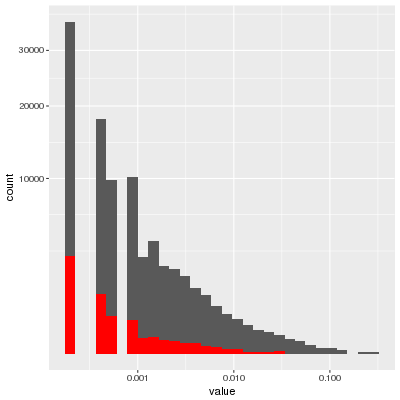

In [51]:
%%R -w 400 -h 400

p1 = ggplot() + 
    geom_histogram(data = allotu, aes(x = value)) + 
    geom_histogram(data = reotu, aes(x = value), fill = "Red") +
    scale_x_log10() +
    scale_y_sqrt()
   
p1

In [53]:
%%R
#what is OTU.4087 abundance in samples organized by plant
O6070 = prune_taxa("OTU.6070", physeq.Full)
plot_bar(06070, "Plant") + 
facet_wrap(~DAP, ncol = 1)


Error in access(object, "otu_table", errorIfNULL) : 
  otu_table slot is empty.


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in access(object, "otu_table", errorIfNULL) : 
  otu_table slot is empty.

  warnings.warn(x, RRuntimeWarning)


In [54]:
%%R 
#proof of concept that deSEQ can handle zeros in the base category
#subset samples to day 79 and hp301
test = physeq.Full %>%
subset_samples(DAP == 79 & Plant == "Hp301" | DAP == 79 & Plant == "BARE" )
# test %>% otu_table %>% print
# test %>% sample_data %>% .$Plant %>% print
dds = phyloseq_to_deseq2(test, ~Treatment + Plant)
d_dds = DESeq(dds, parallel = TRUE)
resultsNames(d_dds) %>% print
DF = results(d_dds)


Error in withVisible({ : could not find function "DESeq"


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required namespace: DESeq2

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: converting counts to integer mode

  warnings.warn(x, RRuntimeWarning)
/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in withVisible({ : could not find function "DESeq"

  warnings.warn(x, RRuntimeWarning)


In [20]:
%%R
sample_sums(test_t)


Error in otu_table(x) : object 'test_t' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in otu_table(x) : object 'test_t' not found

  warnings.warn(x, RRuntimeWarning)


In [55]:
%%R
DF[c("OTU.6070", "OTU.4087"),] %>% print
test_t = prune_taxa(c("OTU.6070", "OTU.4087"), test)
plot_bar(test_t, "Plant") + 
facet_wrap(~OTU)


Error in eval(expr, envir, enclos) : object 'DF' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in eval(expr, envir, enclos) : object 'DF' not found

  warnings.warn(x, RRuntimeWarning)


In [22]:
%%R
plotCounts(dds, gene="OTU.6070", intgroup="Plant", returnData = TRUE)


Error in withVisible({ : could not find function "plotCounts"


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in withVisible({ : could not find function "plotCounts"

  warnings.warn(x, RRuntimeWarning)


## who are the rhizosphere endemic OTUs?

In [23]:
%%R
phy.RE


Error in withVisible({ : object 'phy.RE' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in withVisible({ : object 'phy.RE' not found

  warnings.warn(x, RRuntimeWarning)


In [24]:
%%R
sample_sums(phy.RE)


Error in otu_table(x) : object 'phy.RE' not found


/opt/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in otu_table(x) : object 'phy.RE' not found

  warnings.warn(x, RRuntimeWarning)


In [25]:
%%R -h 1500 -w 1000
phy.RE %>% 
    filter_taxa(function(x) max(x) > 0.005, TRUE) %>%
    plot_tree(shape = "Type", color = "Rank3", label.tips = "Rank6", 
    size = "abundance", plot.margin = 0.5, ladderize = TRUE)


Error in withVisible({ : could not find function "%>%"


# Explore DeSeq output to define core microbiomes

### Read DeSeq output

In [56]:
%%R -i log2foldFile
l2f = read.csv(log2foldFile, header = TRUE)
colnames(l2f)

 [1] "log2FoldChange" "p"              "Rank1"          "Rank2"         
 [5] "Rank3"          "Rank4"          "Rank5"          "Rank6"         
 [9] "Rank7"          "Rank8"          "OTU"            "Day"           
[13] "Plant"          "p.adj"         


In [57]:
%%R
l2f.sig = l2f[l2f$p.adj < .05,]
dim(l2f.sig)

[1] 8597   14


In [58]:
%%R
min(l2f.sig$log2FoldChange)

[1] 0.9609501


### Spread by plant to make matrix of log2fold change in each OTU by plant combo

In [59]:
%%R
df = l2f.sig[,c(1,11,13)]
l2f_m = spread(df, Plant, log2FoldChange, fill = 0, drop = TRUE)
l2f_m %>% head

        OTU   75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
1    OTU.10 3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
2   OTU.100 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
3  OTU.1000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
4 OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
5  OTU.1001 0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
6 OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
     ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H      Ki3
1 3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912 4.357638
2 0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
3 0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
4 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000 0.000000
5 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
6 0.000000 4.359155 0.000000 0.

In [60]:
%%R
dim(l2f_m) %>% print

matrix.please<-function(x) {
    m<-as.matrix(x[,-1])
    rownames(m)<-x[,1]
    m
}
l2f_mat = matrix.please(l2f_m)
head(l2f_mat)

[1] 1506   23
            75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
OTU.10    3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
OTU.100   0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
OTU.1001  0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
             ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H
OTU.10    3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912
OTU.100   0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000
OTU.1001  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10030 0.000000 4.359155 0.000000 

## Ordinate significant log two-fold change

In [61]:
%%R
bc = vegdist(t(l2f_mat), method="bray", binary=TRUE)


In [62]:
%%R
ord <- metaMDS(bc)

Run 0 stress 0.1240072 
Run 1 stress 0.1388799 
Run 2 stress 0.1240075 
... Procrustes: rmse 6.840589e-05  max resid 0.0001927103 
... Similar to previous best
Run 3 stress 0.1536806 
Run 4 stress 0.1240074 
... Procrustes: rmse 7.155556e-05  max resid 0.0002608724 
... Similar to previous best
Run 5 stress 0.1388798 
Run 6 stress 0.1240069 
... New best solution
... Procrustes: rmse 0.0003227803  max resid 0.001182657 
... Similar to previous best
Run 7 stress 0.124007 
... Procrustes: rmse 0.0001834081  max resid 0.0006710754 
... Similar to previous best
Run 8 stress 0.1240071 
... Procrustes: rmse 0.0002534979  max resid 0.0009248619 
... Similar to previous best
Run 9 stress 0.138881 
Run 10 stress 0.1388797 
Run 11 stress 0.1490034 
Run 12 stress 0.1542636 
Run 13 stress 0.1388797 
Run 14 stress 0.1240075 
... Procrustes: rmse 0.000419084  max resid 0.001534133 
... Similar to previous best
Run 15 stress 0.1388799 
Run 16 stress 0.1240069 
... Procrustes: rmse 4.586506e-05  max r

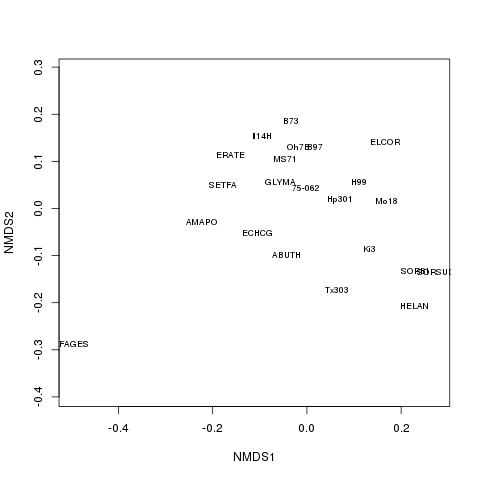

In [63]:
%%R
plot(ord, type = "t")

In [64]:
%%R
pdf(file = "/home/bryan/RhizCG/figures/l2fCluster.pdf")
CL <- hclust(bc, method="average")
CL
plot(CL, main = "Cluster Dendrogram of l2f \n Bray-Curtis Distances")
dev.off()

png 
  2 


$type
[1] "phylogram"

$use.edge.length
[1] TRUE

$node.pos
[1] 1

$node.depth
[1] 1

$show.tip.label
[1] TRUE

$show.node.label
[1] FALSE

$font
[1] 3

$cex
[1] 1

$adj
[1] 0

$srt
[1] 0

$no.margin
[1] FALSE

$label.offset
[1] 0

$x.lim
[1] 0.0000000 0.4229338

$y.lim
[1]  1 22

$direction
[1] "rightwards"

$tip.color
numeric(0)

$Ntip
[1] 22

$Nnode
[1] 21

$root.time
NULL

$align.tip.label
[1] FALSE



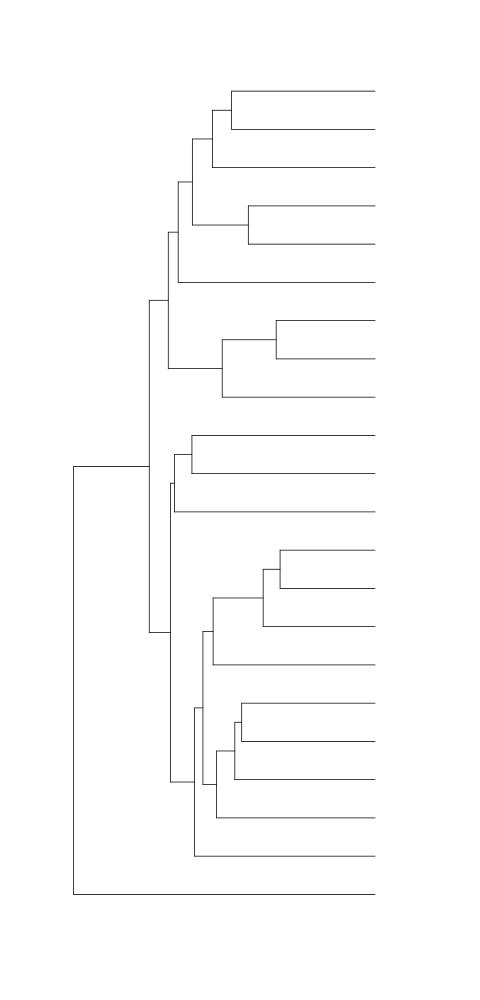

In [65]:
%%R -h 1000
library(ape)
Var = l2f.sig$Day  %>% levels # factor variable for colors
result_phylo <- as.phylo(CL)
p = plot(result_phylo, tip.col = as.numeric(as.character(Var)))
p

## Define l2f cores by group

### Core rhizosphere (all plants)

In [66]:
%%R


rc_sel = apply(l2f_mat, 1,function (x) min(x) > 0)
   
l2f_rhizcore = l2f_mat[rc_sel,]    
Allcore = unique(l2f_rhizcore)
Allcore

            75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
OTU.10    3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
OTU.10253 5.891288 4.852547 6.363949 6.351210 5.331523 5.517604 4.845139
OTU.10288 4.276646 3.085141 3.694847 6.401280 5.676574 3.456203 4.096773
OTU.1034  3.299086 4.204686 4.402033 5.804496 4.685607 2.176160 3.775422
OTU.108   5.631446 8.378662 7.345840 7.097692 5.431812 6.145990 7.452859
OTU.11012 3.188175 3.288303 3.751331 4.541218 3.735438 2.686601 3.797897
OTU.11069 3.586984 2.491399 3.365728 5.485980 4.020008 3.499923 2.864703
OTU.114   3.285204 5.306045 3.926893 4.014599 3.433749 4.007883 3.147667
OTU.1243  4.314674 4.757807 3.722280 5.490029 4.592643 3.619629 5.628495
OTU.134   2.709302 3.181629 2.999717 3.492144 2.774897 2.386902 3.006625
OTU.152   3.085641 3.787463 4.537547 4.156385 3.258488 4.687530 3.508734
OTU.189   4.404056 5.411230 4.184066 4.953385 4.198393 5.186166 4.203979
OTU.196   4.643349 7.799628 5.234562 7.170934 6.553

Rhizosphere Core: 31 OTUs significantly enriched in all rhizospheres

In [68]:
%%R
rownames(Allcore)

 [1] "OTU.10"    "OTU.10253" "OTU.10288" "OTU.1034"  "OTU.108"   "OTU.11012"
 [7] "OTU.11069" "OTU.114"   "OTU.1243"  "OTU.134"   "OTU.152"   "OTU.189"  
[13] "OTU.196"   "OTU.207"   "OTU.24"    "OTU.284"   "OTU.293"   "OTU.4"    
[19] "OTU.4049"  "OTU.414"   "OTU.4513"  "OTU.4888"  "OTU.49"    "OTU.5436" 
[25] "OTU.68"    "OTU.8"     "OTU.9"     "OTU.9377"  "OTU.9421"  "OTU.9501" 
[31] "OTU.96"   


In [81]:
%%R
#Make variable for joining
Taxa = tax_table(physeq.Full) %>% as.data.frame()
Taxa$OTU = row.names(Taxa)

Taxa %>% filter(OTU %in% rownames(Allcore))
#Coretbl$OTU = row.names(Coretbl)

#CoreTaxa = inner_join(Coretbl[,"OTU"], Taxa)


      Rank1           Rank2               Rank3               Rank4
1  Bacteria     Chloroflexi      Chloroflexales Oscillochloridaceae
2  Bacteria Verrucomicrobia            Opitutae          Opitutales
3  Bacteria   Bacteroidetes          Cytophagia        Cytophagales
4  Bacteria   Bacteroidetes    Sphingobacteriia  Sphingobacteriales
5  Bacteria   Bacteroidetes    Sphingobacteriia  Sphingobacteriales
6  Bacteria   Bacteroidetes    Sphingobacteriia  Sphingobacteriales
7  Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
8  Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
9  Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
10 Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
11 Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
12 Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
13 Bacteria  Proteobacteria  Betaproteobacteria     Burkholderiales
14 Bacteria  Proteobacteria  Betaproteobacteria 

In [ ]:
# Check annotation by 

In [74]:
%%R
CoreTaxa

     75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR    ERATE
1  3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262 3.998816
2  5.891288 4.852547 6.363949 6.351210 5.331523 5.517604 4.845139 5.770661
3  4.276646 3.085141 3.694847 6.401280 5.676574 3.456203 4.096773 4.102399
4  3.299086 4.204686 4.402033 5.804496 4.685607 2.176160 3.775422 4.560968
5  5.631446 8.378662 7.345840 7.097692 5.431812 6.145990 7.452859 7.363096
6  3.188175 3.288303 3.751331 4.541218 3.735438 2.686601 3.797897 3.177429
7  3.586984 2.491399 3.365728 5.485980 4.020008 3.499923 2.864703 2.844242
8  3.285204 5.306045 3.926893 4.014599 3.433749 4.007883 3.147667 4.432104
9  4.314674 4.757807 3.722280 5.490029 4.592643 3.619629 5.628495 4.056646
10 2.709302 3.181629 2.999717 3.492144 2.774897 2.386902 3.006625 2.679636
11 3.085641 3.787463 4.537547 4.156385 3.258488 4.687530 3.508734 3.110849
12 4.404056 5.411230 4.184066 4.953385 4.198393 5.186166 4.203979 5.636966
13 4.643349 7.799628 5.23

### Maize

In [15]:
%%R
colnames(l2f_mat)
head(l2f_mat)

            75-062    ABUTH    AMAPO      B73      B97    ECHCG    ELCOR
OTU.10    3.755553 3.554574 3.913238 4.730054 3.983959 4.116643 3.242262
OTU.100   0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 0.000000 0.000000 4.848621 5.219825 0.000000 0.000000 6.751878
OTU.1001  0.000000 0.000000 0.000000 6.053131 6.493816 0.000000 0.000000
OTU.10030 0.000000 0.000000 2.353137 0.000000 0.000000 0.000000 0.000000
             ERATE    FAGES    GLYMA      H99    HELAN    Hp301    Il14H
OTU.10    3.998816 2.226031 4.493125 2.409564 2.879535 4.408774 4.349912
OTU.100   0.000000 1.042526 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.1000  0.000000 1.939025 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10009 5.927989 0.000000 4.524680 0.000000 0.000000 0.000000 0.000000
OTU.1001  0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000
OTU.10030 0.000000 4.359155 0.000000 0.000000 0.000

In [16]:
%%R
maize_mat = l2f_mat[,c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303")] 

c_sel = apply(maize_mat, 1,function (x) min(x) > 0)
   
l2f_maizecore = as.data.frame(maize_mat[c_sel,])   
Maizecore = dim(l2f_maizecore)[1]  
    Maizecore
dummy = rep(1, dim(l2f_maizecore)[1])
OTU = row.names(l2f_maizecore)
MCT = OTU

length(unique(MCT )) 

[1] 103


Maize Core Rhizosphere: 103 OTUs consistently enriched

## C4 grasses not including maize

In [17]:
%%R
C4.nm_mat = l2f_mat[,c("ECHCG",  "ELCOR",  "ERATE", "SETFA",  "SORBI",  "SORSUD")] 

c_sel = apply(C4.nm_mat, 1,function (x) min(x) > 0)
   
l2f_C4.nmcore = as.data.frame(C4.nm_mat[c_sel,])    
C4core = dim(l2f_C4.nmcore)[1]   
OTU = row.names(l2f_C4.nmcore)
dummy = rep(1, dim(l2f_C4.nmcore)[1])
CCT = OTU

CCT  

 [1] "OTU.10"    "OTU.10253" "OTU.10288" "OTU.1034"  "OTU.10692" "OTU.108"  
 [7] "OTU.11012" "OTU.11069" "OTU.112"   "OTU.114"   "OTU.120"   "OTU.12012"
[13] "OTU.1243"  "OTU.125"   "OTU.134"   "OTU.137"   "OTU.15"    "OTU.152"  
[19] "OTU.1628"  "OTU.188"   "OTU.189"   "OTU.194"   "OTU.196"   "OTU.207"  
[25] "OTU.2285"  "OTU.23"    "OTU.24"    "OTU.260"   "OTU.2703"  "OTU.284"  
[31] "OTU.293"   "OTU.297"   "OTU.304"   "OTU.307"   "OTU.321"   "OTU.354"  
[37] "OTU.393"   "OTU.4"     "OTU.4049"  "OTU.407"   "OTU.414"   "OTU.42"   
[43] "OTU.422"   "OTU.4340"  "OTU.4378"  "OTU.440"   "OTU.4513"  "OTU.4888" 
[49] "OTU.49"    "OTU.4954"  "OTU.528"   "OTU.53"    "OTU.5436"  "OTU.556"  
[55] "OTU.57"    "OTU.673"   "OTU.68"    "OTU.7"     "OTU.712"   "OTU.7313" 
[61] "OTU.75"    "OTU.7874"  "OTU.795"   "OTU.8"     "OTU.81"    "OTU.9"    
[67] "OTU.9377"  "OTU.9421"  "OTU.9501"  "OTU.96"    "OTU.976"  


### C4 grasses including maize

In [18]:
%%R
C4_mat = l2f_mat[,c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "ECHCG",  "ELCOR",  "ERATE", "SETFA",  "SORBI",  "SORSUD")] 

c_sel = apply(C4_mat, 1,function (x) min(x) > 0)
   
l2f_C4core = C4_mat[c_sel,]    
 dim(l2f_C4core)[1] 


 

[1] 50


### Chloridoideae subfamily

In [19]:
%%R
Chloridoideae.mat = l2f_mat[, c("ERATE", "ELCOR")]

c_sel = apply(Chloridoideae.mat, 1,function (x) min(x) > 0)
    Chloridoideae.core = Chloridoideae.mat[c_sel,]    
 dim(Chloridoideae.core)[1]

ChCT = cbind(row.names( Chloridoideae.core), rep(1, length(row.names(Chloridoideae.core)))) %>% as.data.frame
    colnames(ChCT) = c("OTU", "ChloridoideaeCore")
    ChCT

          OTU ChloridoideaeCore
1      OTU.10                 1
2   OTU.10009                 1
3   OTU.10219                 1
4   OTU.10253                 1
5   OTU.10288                 1
6   OTU.10329                 1
7    OTU.1034                 1
8    OTU.1039                 1
9     OTU.104                 1
10  OTU.10442                 1
11  OTU.10472                 1
12  OTU.10520                 1
13  OTU.10604                 1
14  OTU.10692                 1
15   OTU.1070                 1
16  OTU.10763                 1
17    OTU.108                 1
18   OTU.1092                 1
19   OTU.1098                 1
20  OTU.11012                 1
21  OTU.11069                 1
22    OTU.112                 1
23   OTU.1123                 1
24  OTU.11302                 1
25    OTU.114                 1
26    OTU.117                 1
27    OTU.120                 1
28  OTU.12012                 1
29  OTU.12023                 1
30   OTU.1207                 1
31  OTU.

### Panicoideae subfamily 

In [20]:
%%R
Panicoideae.mat = l2f_mat[, c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "SETFA", "ECHCG", "SORSUD", "SORBI")]

c_sel = apply(Panicoideae.mat, 1,function (x) min(x) > 0)
    Panicoideae.core = Panicoideae.mat[c_sel,]    
 dim(Panicoideae.core)[1]
     dim(Panicoideae.core)[1]
        PCT = cbind(row.names( Panicoideae.core), rep(1, length(row.names(Panicoideae.core)))) %>% as.data.frame
    colnames(PCT) = c("OTU", "PanicoideaeCore")
    PCT

         OTU PanicoideaeCore
1     OTU.10               1
2  OTU.10253               1
3  OTU.10288               1
4   OTU.1034               1
5  OTU.10692               1
6    OTU.108               1
7  OTU.11012               1
8  OTU.11069               1
9    OTU.114               1
10   OTU.120               1
11 OTU.12012               1
12  OTU.1243               1
13   OTU.125               1
14   OTU.134               1
15   OTU.137               1
16    OTU.15               1
17   OTU.152               1
18   OTU.188               1
19   OTU.189               1
20   OTU.196               1
21  OTU.2000               1
22   OTU.207               1
23    OTU.23               1
24    OTU.24               1
25  OTU.2703               1
26   OTU.277               1
27   OTU.284               1
28   OTU.293               1
29   OTU.304               1
30   OTU.307               1
31   OTU.321               1
32  OTU.3548               1
33  OTU.3910               1
34     OTU.4  

## Panicoideae/Paniceae

In [21]:
%%R
Paniceae.mat = l2f_mat[, c("ECHCG", "SETFA")]

c_sel = apply(Paniceae.mat, 1,function (x) min(x) > 0)
    Paniceae.core = Paniceae.mat[c_sel,]    
 dim(Paniceae.core)[1]
        P_PCT = cbind(row.names( Paniceae.core), rep(1, length(row.names(Paniceae.core)))) %>% as.data.frame
    colnames(P_PCT) = c("OTU", "PaniceaeCore")
    P_PCT

          OTU PaniceaeCore
1      OTU.10            1
2     OTU.101            1
3   OTU.10221            1
4   OTU.10249            1
5   OTU.10253            1
6   OTU.10288            1
7    OTU.1034            1
8    OTU.1039            1
9   OTU.10692            1
10   OTU.1073            1
11  OTU.10763            1
12   OTU.1078            1
13    OTU.108            1
14   OTU.1092            1
15   OTU.1094            1
16  OTU.10966            1
17  OTU.11012            1
18  OTU.11069            1
19    OTU.112            1
20    OTU.114            1
21   OTU.1141            1
22   OTU.1149            1
23  OTU.11804            1
24   OTU.1195            1
25  OTU.11995            1
26    OTU.120            1
27  OTU.12012            1
28    OTU.123            1
29   OTU.1233            1
30  OTU.12373            1
31   OTU.1242            1
32   OTU.1243            1
33    OTU.125            1
34  OTU.12628            1
35   OTU.1272            1
36   OTU.1279            1
3

## Panicoideae/Anropogoneae


In [22]:
%%R
Andropogoneae.mat = l2f_mat[, c("75-062", "B73", "B97", "H99","Hp301",  "Il14H",  "Ki3", "Mo18", "MS71", 
                       "Oh7B", "Tx303", "SORSUD", "SORBI")]

c_sel = apply(Andropogoneae.mat, 1,function (x) min(x) > 0)
    Andropogoneae.core = Andropogoneae.mat[c_sel,]    
 dim(Andropogoneae.core)[1]
    Andropogoneae.core
    ACT = cbind(row.names( Andropogoneae.core), rep(1, length(row.names(Andropogoneae.core)))) %>% as.data.frame
    colnames(ACT) = c("OTU", "AndropogoneaeCore")
    ACT

         OTU AndropogoneaeCore
1     OTU.10                 1
2  OTU.10253                 1
3  OTU.10288                 1
4   OTU.1034                 1
5    OTU.104                 1
6  OTU.10472                 1
7  OTU.10692                 1
8    OTU.108                 1
9   OTU.1098                 1
10 OTU.11012                 1
11 OTU.11069                 1
12   OTU.114                 1
13   OTU.120                 1
14 OTU.12012                 1
15 OTU.12414                 1
16  OTU.1243                 1
17   OTU.125                 1
18   OTU.134                 1
19   OTU.137                 1
20    OTU.15                 1
21   OTU.152                 1
22   OTU.188                 1
23   OTU.189                 1
24   OTU.196                 1
25   OTU.197                 1
26   OTU.200                 1
27  OTU.2000                 1
28   OTU.202                 1
29   OTU.207                 1
30    OTU.23                 1
31    OTU.24                 1
32    OT

### Dicots

In [23]:
%%R
Dicot_mat = l2f_mat[,c("AMAPO", "ABUTH", "FAGES", "HELAN", "GLYMA")] 

c_sel = apply(Dicot_mat, 1,function (x) min(x) > 0)
   
l2f_Dicotcore = Dicot_mat[c_sel,]    
Dicotcore = dim(l2f_Dicotcore)[1] 
dummy = rep(1, dim(l2f_Dicotcore)[1])
OTU = row.names(l2f_Dicotcore)
DCT = OTU
#colnames(DCT) = c("OTU", "dummy")
DCT

 [1] "OTU.10"    "OTU.10249" "OTU.10253" "OTU.10288" "OTU.1034"  "OTU.104"  
 [7] "OTU.10472" "OTU.108"   "OTU.11012" "OTU.11069" "OTU.112"   "OTU.114"  
[13] "OTU.12023" "OTU.1242"  "OTU.1243"  "OTU.134"   "OTU.1403"  "OTU.152"  
[19] "OTU.162"   "OTU.1628"  "OTU.173"   "OTU.189"   "OTU.194"   "OTU.196"  
[25] "OTU.200"   "OTU.207"   "OTU.2285"  "OTU.24"    "OTU.260"   "OTU.284"  
[31] "OTU.293"   "OTU.336"   "OTU.3910"  "OTU.4"     "OTU.4049"  "OTU.406"  
[37] "OTU.414"   "OTU.4340"  "OTU.4423"  "OTU.4513"  "OTU.4888"  "OTU.49"   
[43] "OTU.536"   "OTU.5436"  "OTU.641"   "OTU.671"   "OTU.68"    "OTU.704"  
[49] "OTU.7259"  "OTU.8"     "OTU.9"     "OTU.9174"  "OTU.9377"  "OTU.9421" 
[55] "OTU.9501"  "OTU.96"   


## Create Venn Diagram

In [24]:
%%R
#Create tables that will be basis of comparisons
#Add OTU
#All plants
A1 = length(MCT) #Maize
A2 = length(CCT) #C4 grasses
A3 = length(DCT) #Dictos
A12 = length(unique(intersect(MCT, CCT)))
A13 = length(unique(intersect(MCT, DCT)))
A23 = length(unique(intersect(CCT, DCT)))
A123 = Allcore
A2

[1] 71


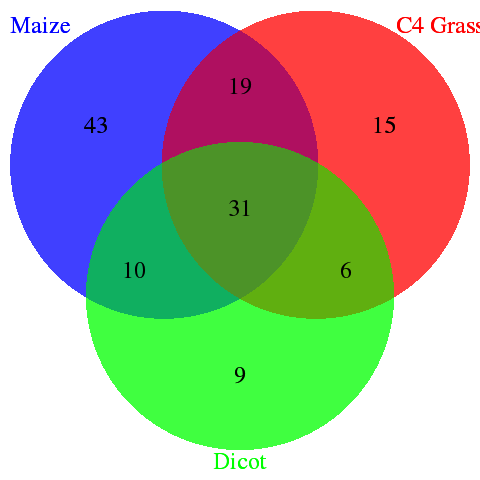

In [25]:
%%R


#Draw venn diagram 
venn.plot <- draw.triple.venn(
area1 = A1,
area2 = A2,
area3 = A3,
n12 = A12,
n23 = A23,
n13 = A13,
n123 = A123,
category = c("Maize", "C4 Grass", "Dicot"),
euler.d = TRUE, 
fill = c("blue", "red", "green"),
lty = "blank",
cex = 2,
cat.cex = 2,
cat.col = c("blue", "red", "green")
);
grid.draw(venn.plot);
grid.newpage();



# area1 = 65,
# area2 = 75,
# area3 = 85,
# n12 = 35,
# n23 = 15,
# n13 = 25,
# n123 = 5,

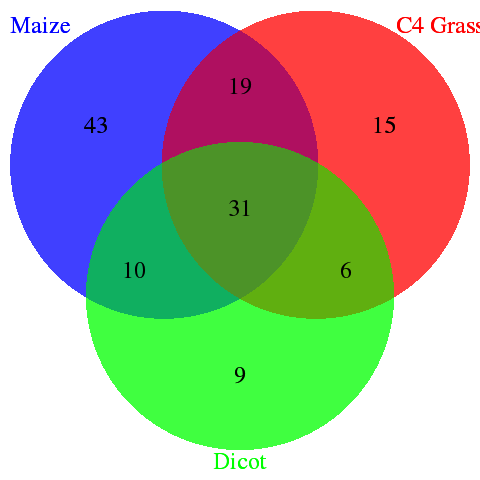

In [26]:
%%R
#Draw venn diagram 
venn.plot <- draw.triple.venn(
area1 = A1,
area2 = A2,
area3 = A3,
n12 = A12,
n23 = A23,
n13 = A13,
n123 = A123,
category = c("Maize", "C4 Grass", "Dicot"),
euler.d = TRUE, 
fill = c("blue", "red", "green"),
lty = "blank",
cex = 2,
cat.cex = 2,
cat.col = c("blue", "red", "green")
);
grid.draw(venn.plot);
grid.newpage();





## Core on a sampling date

### Day 53

In [27]:
%%R
Date_mat = l2f_mat[,c("AMAPO", "ECHCG")] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)   

[1] 233   5


### Day 57

In [28]:
%%R
Date_mat = l2f_mat[,c("GLYMA", "ABUTH")] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)  

[1] 226   5


### Day 72

In [29]:
%%R
Date_mat = l2f_mat[,c("75-062","ERATE","H99","Il14H",  "MS71" )] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore) 


[1] 162   5


### Day 79

In [30]:
%%R
Date_mat = l2f_mat[,c("B73" ,  "B97"  , "Hp301", "Oh7B"  )] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore) 


[1] 276   5


### Day 84

In [31]:
%%R
Date_mat = l2f_mat[,c("HELAN" , "SORBI" , "SORSUD"  )] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)

[1] 100   5


### Day 88

In [32]:
%%R
Date_mat = l2f_mat[,c("ELCOR", "Ki3" ,  "Mo18" , "Tx303")] 

c_sel = apply(Date_mat, 1,function (x) min(x) > 0)
   
l2f_dateCore = Dicot_mat[c_sel,]    
dim(l2f_dateCore)

[1] 105   5


# Core members

## All rhizosphere core

In [33]:
%%R
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3')
physeq.Full = readRDS(F)
sd = sample_data(physeq.Full)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Any core

In [36]:
%%R
# collect three core groups: Maize, C4 grasses, Dicots
#c(DCT, MCT, CCT) %>% unique
DicotTbl = cbind(DCT, as.numeric(rep(1,length(DCT)))) %>% as.data.frame
colnames(DicotTbl) = c("OTU", "DicotCore")
DicotTbl

MaizeTbl = cbind(MCT, rep(1,length(MCT))) %>% as.data.frame
colnames(MaizeTbl) = c("OTU", "MaizeCore")
MaizeTbl

C4Tbl = cbind(CCT, rep(1,length(CCT))) %>% as.data.frame
colnames(C4Tbl) = c("OTU", "C4Core")
C4Tbl

CoreDF = full_join(MaizeTbl, C4Tbl, by = "OTU")
CoreDF = full_join(CoreDF, DicotTbl, by = "OTU")

CoreDF = full_join(CoreDF, PCT, by = "OTU")
CoreDF = full_join(CoreDF, P_PCT, by = "OTU")
CoreDF = full_join(CoreDF, ACT, by = "OTU")
CoreDF = full_join(CoreDF, ChCT, by = "OTU")

CoreDF

write.csv(CoreDF, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/CoreTaxa.csv')

In [ ]:
%%R
head(CoreDF)

# Format table for use in heatmap notebook


In [45]:
%%R
df = CoreDF %>% melt(id = "OTU") 
colnames(df)[2] = "Test"
df = mutate(df, padj = ifelse(value == 1, 0, 1),
           direction = ifelse(value == 1, "Pos", NA))
df

           OTU              Test value padj direction
1       OTU.10         MaizeCore     1    0       Pos
2      OTU.101         MaizeCore     1    0       Pos
3    OTU.10253         MaizeCore     1    0       Pos
4    OTU.10288         MaizeCore     1    0       Pos
5     OTU.1034         MaizeCore     1    0       Pos
6      OTU.104         MaizeCore     1    0       Pos
7    OTU.10442         MaizeCore     1    0       Pos
8    OTU.10472         MaizeCore     1    0       Pos
9    OTU.10692         MaizeCore     1    0       Pos
10     OTU.107         MaizeCore     1    0       Pos
11   OTU.10763         MaizeCore     1    0       Pos
12     OTU.108         MaizeCore     1    0       Pos
13    OTU.1098         MaizeCore     1    0       Pos
14   OTU.11012         MaizeCore     1    0       Pos
15   OTU.11069         MaizeCore     1    0       Pos
16   OTU.11302         MaizeCore     1    0       Pos
17     OTU.114         MaizeCore     1    0       Pos
18     OTU.120         Maize

In [46]:
%%R
write.table(df, file = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/CoreOTUs.txt', sep = "\t")